In [1]:
# based on https://wroscoe.github.io/keras-lane-following-autopilot.html

import os
import urllib.request
import pickle
import numpy as np
import cv2

%matplotlib inline
import matplotlib
from matplotlib.pyplot import imshow

# Get Data

X shape: (13408, 128, 160, 3)
y shape:  (13408,)


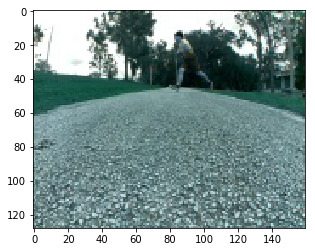

In [2]:
import csv
raw_X = []
raw_y = []
data_path = '../loop1'
with open(data_path + '/capture_log.csv', 'r') as f:
    reader = csv.reader(f)
    iterreader = iter(reader)
    next(iterreader)
    count = 0
    for row in iterreader:
        img = cv2.imread(data_path + row[0][1:])
        raw_X.append(img) 
        raw_y.append(float(row[2]))
    raw_X = np.array(raw_X)
    raw_y = np.array(raw_y)
    print('X shape:', raw_X.shape)
    print('y shape: ', raw_y.shape)
    imshow(raw_X[2])

In [3]:
def shuffle_data(X, y):
    assert len(X) == len(y)
    p = np.random.permutation(len(X))
    return X[p], y[p]

shuffled_X, shuffled_y = shuffle_data(raw_X, raw_y)

In [4]:
test_cutoff = int(len(raw_X) * 0.8)
val_cutoff = test_cutoff + int(len(raw_X) * 0.1)

train_X, train_y = shuffled_X[:test_cutoff], shuffled_y[:test_cutoff]
val_X, val_y = shuffled_X[test_cutoff:val_cutoff], shuffled_y[test_cutoff:val_cutoff]
test_X, test_y = shuffled_X[val_cutoff:], shuffled_y[val_cutoff:]

print(len(train_X))
print(len(val_X))
print(len(test_X))

10726
1340
1342


In [5]:
# flip images to remove steering bias
X_flipped = np.array([np.fliplr(i) for i in train_X])
y_flipped = np.array([-i for i in train_y])
train_X = np.concatenate([train_X, X_flipped])
train_y = np.concatenate([train_y, y_flipped])
len(train_X)

21452

In [6]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D

Using TensorFlow backend.


# Model used by William Roscoe for the Donkey SDC

In [7]:
model = Sequential()
model.add(Convolution2D(8, (3,3), input_shape=(128, 160, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(16, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('linear'))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 158, 8)       224       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 158, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 79, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 77, 16)        1168      
_________________________________________________________________
activation_2 (Activation)    (None, 61, 77, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 38, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 36, 32)        4640      
__________

# Train

In [8]:
from keras import callbacks
model_path = os.getcwd() + '/models/model_bs8.hdf5'
save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]

In [9]:
model.fit(train_X, train_y, batch_size=8, epochs=4, validation_data=(val_X, val_y), callbacks=callbacks_list)

Train on 21452 samples, validate on 1340 samples
Epoch 1/4
21452/21452 [==============================] - 320s - loss: 433.6774 - val_loss: 0.0135
Epoch 2/4
21452/21452 [==============================] - 299s - loss: 0.0113 - val_loss: 0.0076
Epoch 3/4
21452/21452 [==============================] - 332s - loss: 0.0076 - val_loss: 0.0073
Epoch 4/4
21452/21452 [==============================] - 290s - loss: 0.0065 - val_loss: 0.0069


# Evaluate

In [10]:
import pandas as pd
from keras.models import load_model
model = load_model(model_path)
pred_y = model.predict(test_X)
pred_y = pred_y.reshape((pred_y.shape[0],))

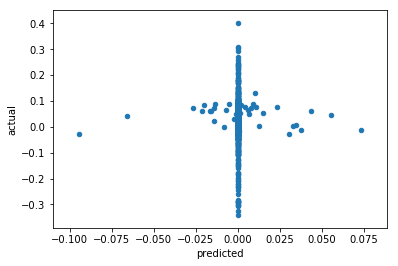

In [11]:
df = pd.DataFrame({'predicted':pred_y, 'actual':test_y})
ax = df.plot.scatter('predicted', 'actual')

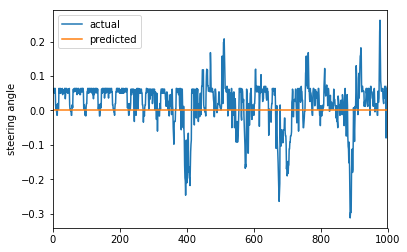

In [12]:
pred_y_2 = model.predict(raw_X[:1000])
pred_y_2 = pred_y_2.reshape((pred_y_2.shape[0],))

ax = pd.DataFrame({'predicted':pred_y_2, 'actual':raw_y[:1000]}).plot()
ax.set_ylabel('steering angle')

In [13]:
r1 = 900
r2 = 930
print(model.predict(raw_X[r1:r2]))
print(raw_y[r1:r2])

[[ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]
 [ 0.00027732]]
[-0.052 -0.09  -0.034  0.012  0.004  0.054  0.13   0.104  0.02   0.008
  0.008 -0.012  0.002  0.094  0.108  0.036  0.086  0.126  0.158  0.158
  0.182  0.168  0.072  0.054  0.07   0.07   0.056  0.056  0.056  0.056]
